In [1]:
# Barron functions:
## Linear functions f(x) = a^Tx + b
## Radial Basis Functions (RBF) f(x) = exp(-gamma * ||x - c||^2)
## Trigonomial functions f(x) = cos(ax) and sin(ax)

In [96]:
import numpy as np
import ot

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn
seaborn.set_theme()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [97]:
from src.function_distrib import FunctionDistrib

n = 100
d = 3
l = 3

linear_functions = FunctionDistrib(n, d, l, function_type="linear", prior="uniform_cube")

linear_functions.Z.shape, linear_functions.Y.shape

((100, 3), (100, 1))

In [95]:
x = np.array([[0.5, 0.6], [0.1, 0.9]]).reshape(-1, 2)

for i in range(len(trainer.function_distrib.functions)):
    x = trainer.function_distrib.functions[i](x)
    print(x)


[[0.62245933 0.64565631]
 [0.52497919 0.7109495 ]]
[[0.65077768 0.65603095]
 [0.62831133 0.67061093]]
[[0.65718569 0.65836823]
 [0.65210646 0.66163994]]
[[0.65862791 0.65889374]
 [0.65748499 0.65962868]]
[[ -5.2607137   -6.34005463]
 [-16.24892201 -17.34840038]]


In [101]:
from src.trainer import Trainer

config = {
    "function_distrib":{
        "n": 1000,
        "d": 2,
        "l": 5,
        "output_size": 2,
        "function_type": "linear-sigmoid",
        "output_function": "linear",
        "prior": "gaussian", # uniform_cube, uniform_ball, gaussian, gaussian_mixture
        "seed": 1,
    },

    "model": {
        # "input_size": # infer
        # "output_size": # infer
        "hidden_size": 40,
        "n_hidden_layers": 2
    },

    "optimizer": {
        "lr": 0.001,
    },

    "epochs": 300,
}

trainer = Trainer(config, is_debug=False)
trainer.function_distrib.get_function_types()
losses, w2_distances = trainer.train()

Layer 0: sigmoid
Layer 1: sigmoid
Layer 2: sigmoid
Layer 3: sigmoid
Layer 4: linear


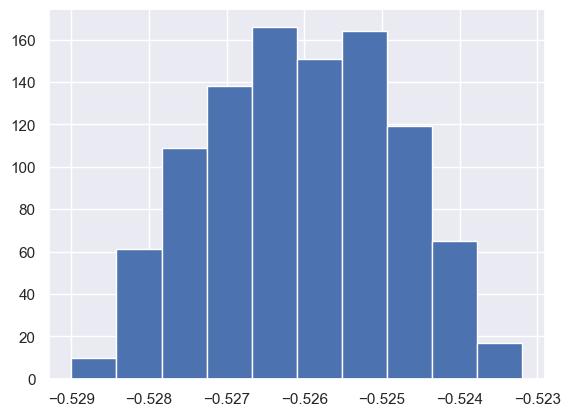

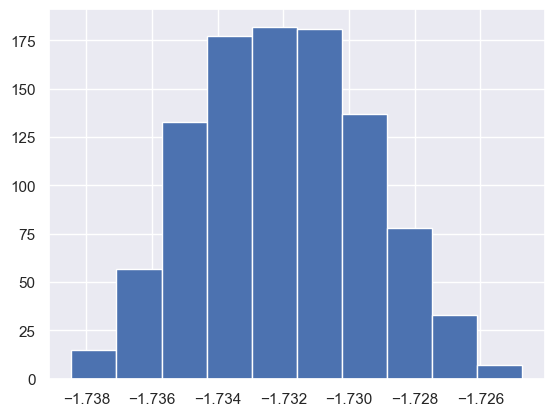

In [89]:
plt.hist(trainer.function_distrib.Y[:, 0])
plt.show()
plt.hist(trainer.function_distrib.Y[:, 1])
plt.show()


array([<Axes3D: title={'center': 'Input distribution'}>,
       <Axes3D: title={'center': 'Original Output distribution'}>,
       <Axes3D: title={'center': 'NN Output distribution'}>], dtype=object)

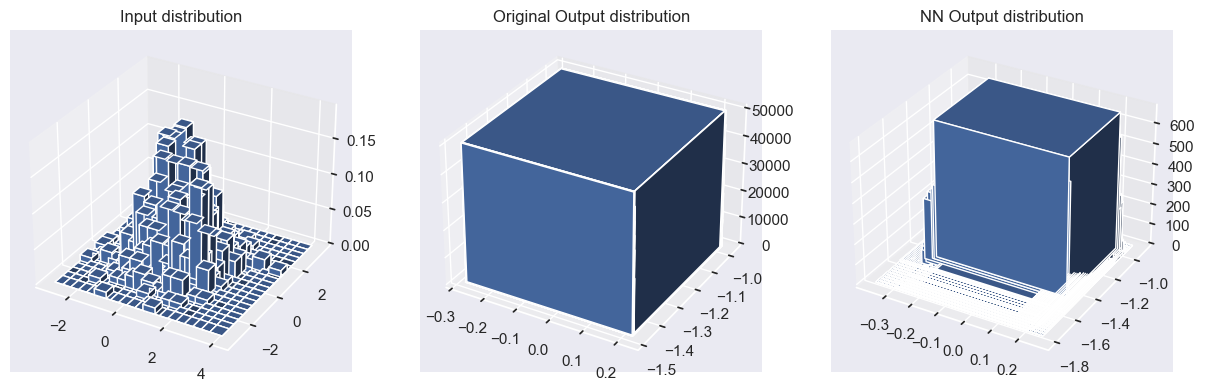

In [86]:
trainer.plot_input_output()

Uniform cube
Uniform ball
Gaussian
Gaussian mixture


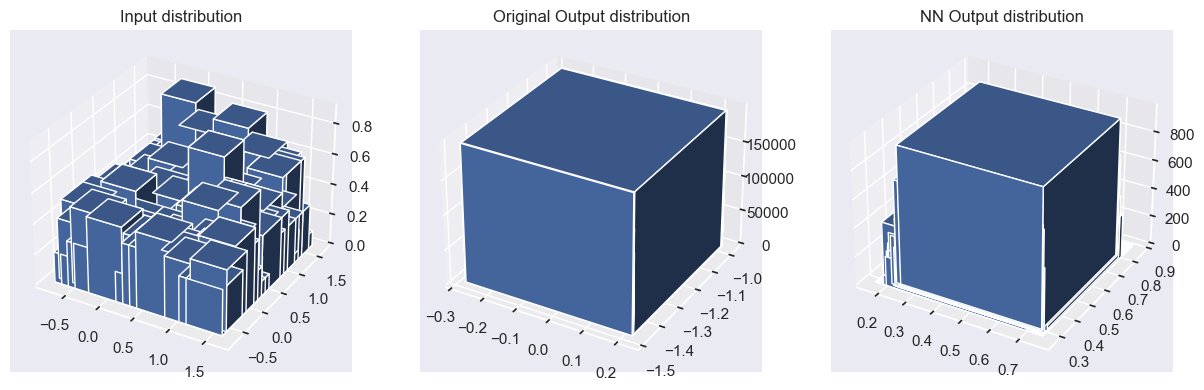

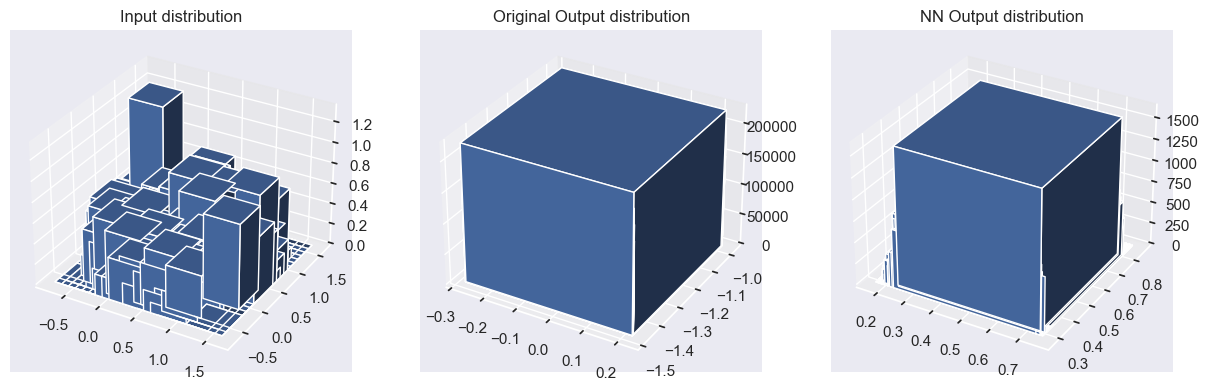

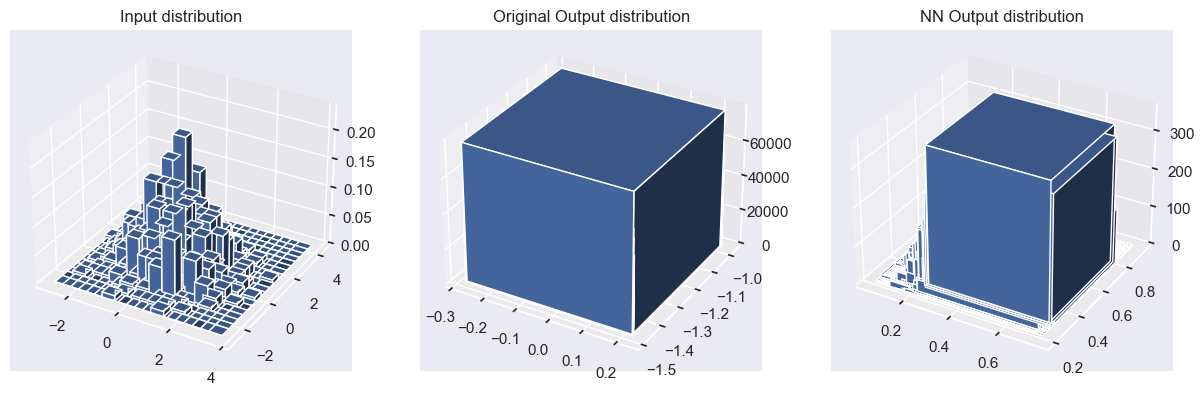

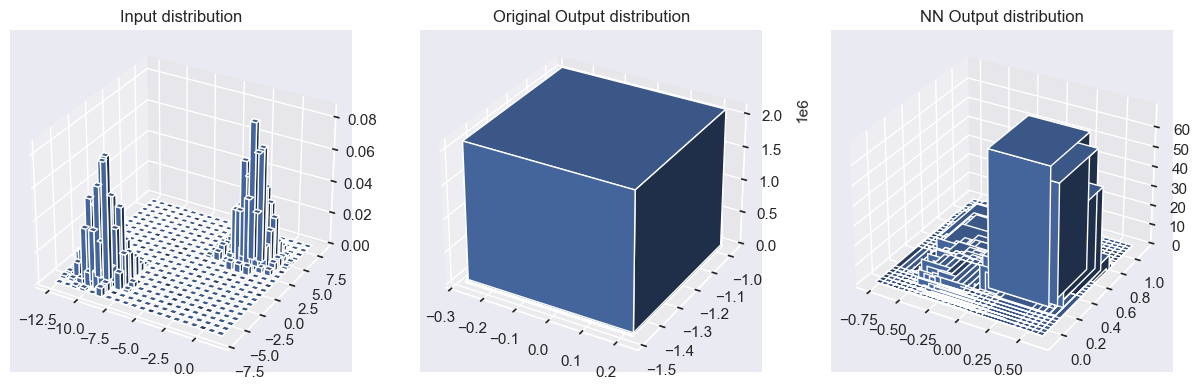

In [77]:
priors = ["uniform_cube", "uniform_ball", "gaussian", "gaussian_mixture"]
titles = ["Uniform cube", "Uniform ball", "Gaussian", "Gaussian mixture"]

for i, prior in enumerate(priors):
    config_prior = config.copy()
    config_prior["function_distrib"]["prior"] = prior
    print(titles[i])
    trainer = Trainer(config_prior)
    trainer.plot_input_output()

In [6]:
trainer.function_distrib.Y

array([[-1.15098231,  0.00616315],
       [-1.15098231,  0.00616315],
       [-1.15098231,  0.00616315],
       ...,
       [-1.15098231,  0.00616315],
       [-1.1509823 ,  0.00616314],
       [-1.15098231,  0.00616315]])

In [7]:
hidden_sizes = [5, 10, 20, 50, 100, 200, 500]
ls = [1, 2, 3, 10, 15]
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

losses = np.zeros((len(seeds), len(hidden_sizes), len(ls)))
w2_distances = np.zeros((len(seeds), len(hidden_sizes), len(ls)))

for s in seeds:
    for i, hidden_size in enumerate(hidden_sizes):
        for j, l in enumerate(ls):
            config["function_distrib"]["seed"] = s
            config["model"]["hidden_size"] = hidden_size
            config["function_distrib"]["l"] = l
            trainer = Trainer(config)
            loss, w2 = trainer.train(plot=False)
            losses[s, i, j] = loss[-1]
            w2_distances[s, i, j] = w2[-1]

function_type: linear
input_size: 2
output_size: 2
function_type: linear
input_size: 2
output_size: None
function_type: linear
input_size: 1
output_size: 2
function_type: linear
input_size: 2
output_size: None
function_type: rbf
input_size: 1
output_size: None
function_type: linear
input_size: 1
output_size: 2
function_type: linear
input_size: 2
output_size: None
function_type: rbf
input_size: 1
output_size: None
function_type: rbf
input_size: 1
output_size: None
function_type: rbf
input_size: 1
output_size: None
function_type: rbf
input_size: 1
output_size: None
function_type: rbf
input_size: 1
output_size: None
function_type: rbf
input_size: 1
output_size: None
function_type: rbf
input_size: 1
output_size: None
function_type: rbf
input_size: 1
output_size: None
function_type: linear
input_size: 1
output_size: 2
function_type: linear
input_size: 2
output_size: None
function_type: rbf
input_size: 1
output_size: None
function_type: rbf
input_size: 1
output_size: None
function_type: rbf


KeyboardInterrupt: 

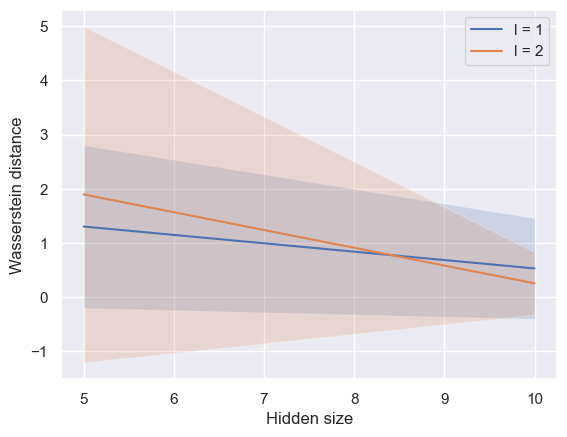

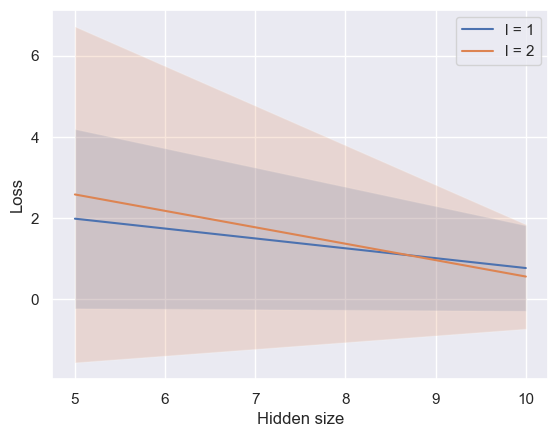

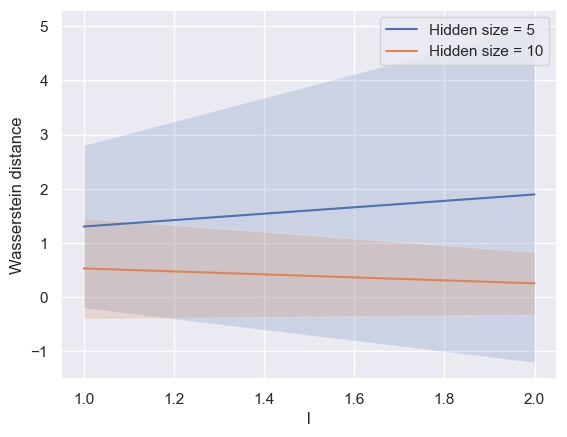

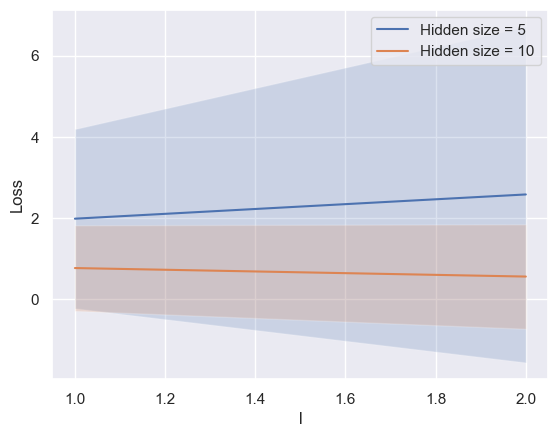

In [11]:
for i, l in enumerate(ls):
    mean = np.mean(w2_distances[:, :, i], axis=0)
    std_dev = np.std(w2_distances[:, :, i], axis=0)
    plt.plot(hidden_sizes, mean, label='l = {}'.format(l))
    plt.fill_between(hidden_sizes, mean - std_dev, mean + std_dev, alpha=0.2)
plt.ylabel('Wasserstein distance')
plt.xlabel('Hidden size')
plt.legend()
plt.show()

for i, l in enumerate(ls):
    mean = np.mean(losses[:, :, i], axis=0)
    std_dev = np.std(losses[:, :, i], axis=0)
    plt.plot(hidden_sizes, mean, label='l = {}'.format(l))
    plt.fill_between(hidden_sizes, mean - std_dev, mean + std_dev, alpha=0.2)
plt.ylabel('Loss')
plt.xlabel('Hidden size')
plt.legend()
plt.show()

for i, hidden_size in enumerate(hidden_sizes):
    mean = np.mean(w2_distances[:, i, :], axis=0)
    std_dev = np.std(w2_distances[:, i, :], axis=0)
    plt.plot(ls, mean, label='Hidden size = {}'.format(hidden_size))
    plt.fill_between(ls, mean - std_dev, mean + std_dev, alpha=0.2)
plt.ylabel('Wasserstein distance')
plt.xlabel('l')
plt.legend()
plt.show()

for i, hidden_size in enumerate(hidden_sizes):
    mean = np.mean(losses[:, i, :], axis=0)
    std_dev = np.std(losses[:, i, :], axis=0)
    plt.plot(ls, mean, label='Hidden size = {}'.format(hidden_size))
    plt.fill_between(ls, mean - std_dev, mean + std_dev, alpha=0.2)
plt.ylabel('Loss')
plt.xlabel('l')
plt.legend()
plt.show()